In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import torch 
import torch.nn.functional as F
from torch.autograd.functional import hessian
from torch.distributions.multivariate_normal import MultivariateNormal
import seaborn as sns
import io
import base64

In [35]:
import warnings
warnings.filterwarnings('ignore')

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 05: Processos Gaussianos para regressão

**1.** Durante a aula, discutimos como construir uma priori GP e o formato da posteriori preditiva para problemas de regressão com verossimilhança Gaussiana (com média definida pelo GP). O código abaixo cria um GP com kernel exponencial quadrático, mostra a priori preditiva e a posteriori preditiva. Experimente com o código e comente a influência de ambos os parâmetros do kernel exponencial quadrático, tanto na priori preditiva quanto na posteriori preditiva. Nos gráficos gerados, os pontos vermelhos são observações, as curvas sólidas azuis são a médias das preditivas e o sombreado denota +- um desvio padrão.

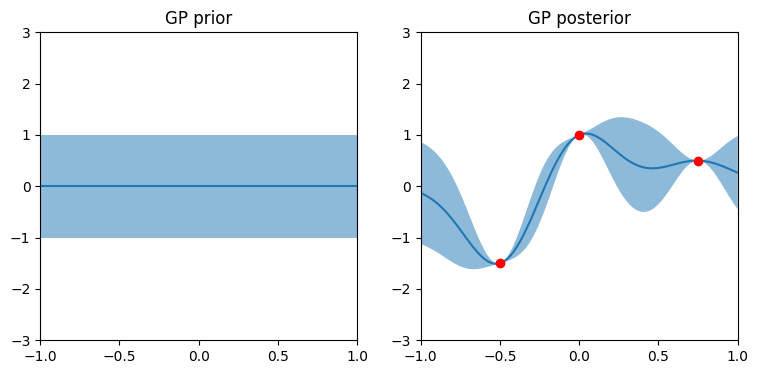

In [36]:
SEED = 42
np.random.seed(SEED)

s2 = 1e-04 # variância observacional

def rbf_kernel(x1, x2, gamma=10.0, c=1.0):
    assert(gamma>0)
    assert(c>0)
    return (-gamma*(torch.cdist(x1, x2)**2)).exp()*c

x = torch.linspace(-1, 1, 100)[:, None]

K = rbf_kernel(x, x) + torch.eye(x.shape[0])*s2
mu = torch.zeros_like(x)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))

axs[0].plot(x, mu)
axs[0].fill_between(x.flatten(), mu.flatten()-K.diag(), mu.flatten()+K.diag(), alpha=0.5)
axs[0].set_xlim([-1, 1])
axs[0].set_ylim([-3, 3])
axs[0].set_title('GP prior')


xtrain = torch.tensor([-0.5, 0.0, 0.75])[:, None]
ytrain = torch.tensor([-1.5, 1.0, 0.5])[:, None]

def posterior_pred(x, xt, yt, gamma=10.0, c=1.0):
    Kxxt = rbf_kernel(x, xt, gamma, c)
    Kxt = rbf_kernel(xt, xt, gamma, c) + torch.eye(xt.shape[0])*s2
    Kinv = torch.linalg.inv(Kxt)
    Kxx = rbf_kernel(x, x, gamma, c)
    
    mu = Kxxt @ Kinv @ yt
    cov = Kxx - Kxxt @ Kinv @ Kxxt.T
    return mu, cov

post_mu, post_cov = posterior_pred(x, xtrain, ytrain)
axs[1].plot(x, post_mu)
axs[1].fill_between(x.flatten(), post_mu.flatten()-post_cov.diag(), post_mu.flatten()+post_cov.diag(), alpha=0.5)
axs[1].scatter(xtrain, ytrain, color='red', zorder=5)

axs[1].set_xlim([-1, 1])
axs[1].set_ylim([-3, 3])
axs[1].set_title('GP posterior')

plt.show()

Vamos definir vários possíveis valores para $c$ e $\gamma$

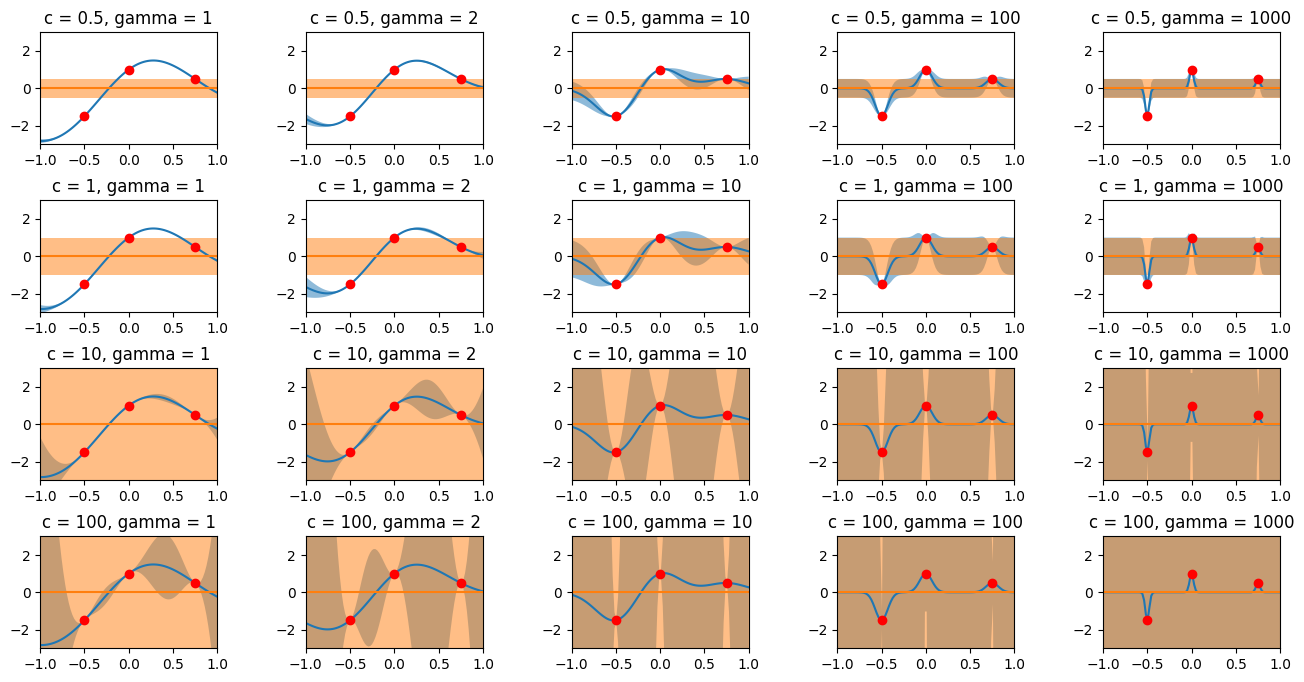

In [37]:
cValues = [0.5, 1, 10, 100]
gammaValues = [1, 2, 10, 100, 1000]

fig, axs = plt.subplots(4, 5, figsize=(16, 8))
for c in range(len(cValues)):
    for gamma in range(len(gammaValues)):
        # posterior
        post_mu, post_cov = posterior_pred(x, xtrain, ytrain, gammaValues[gamma], cValues[c])
        axs[c, gamma].plot(x, post_mu)
        axs[c, gamma].fill_between(x.flatten(), post_mu.flatten()-post_cov.diag(), post_mu.flatten()+post_cov.diag(), alpha=0.5)
        axs[c, gamma].scatter(xtrain, ytrain, color='red', zorder=5)
        axs[c, gamma].set_xlim([-1, 1])
        axs[c, gamma].set_ylim([-3, 3])
        axs[c, gamma].set_title('c = {}, gamma = {}'.format(cValues[c], gammaValues[gamma]))

        # prior
        K = rbf_kernel(x, x, gammaValues[gamma], cValues[c]) + torch.eye(x.shape[0])*s2
        mu = torch.zeros_like(x)
        axs[c, gamma].plot(x, mu)
        axs[c, gamma].fill_between(x.flatten(), mu.flatten()-K.diag(), mu.flatten()+K.diag(), alpha=0.5)
        axs[c, gamma].set_xlim([-1, 1])
        axs[c, gamma].set_ylim([-3, 3])
        axs[c, gamma].set_title('c = {}, gamma = {}'.format(cValues[c], gammaValues[gamma]))
        # set color of prior to orange. do not change the color of the posterior

# increase space between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

O teste dos parâmetros ilumina algumas questões. Em primeiro lugar, uma análise atenta permite observar que a priori não sofre alterações quando alteramos $\gamma$ e mantemos $c$ constante, i.e., $\gamma$ não influencia na priori. Por outro lado, $\gamma$ está diretamente associada à suavidade da posteriori e ao grau de incerteza. Valores mais altos para $\gamma$ resultam em curvas acentuadas e com maior incerteza - afinal, o gráfico mostra que ela se altera mais rapidamente somente para alcançar os pontos. No entanto, $\gamma$ pequeno resulta em curvas mais suaves e com menor incerteza - no caso de $\gamma = 1$ e $c = 0.5$, note que o desvio padrão é imperceptível. É claro, há o efeito de $c$ baixo neste caso, mas mesmo quando comparamos com valores de $c$ mais altos, $\gamma$ parece refletir maior efeito na suavidade da curva e na baixa incerteza.

A mudança nos valores de $c$ no caso da priori são de verificação imediata pela própria fórmula, na medida em que $c$ determina a amplitude do desvio padrão. Naturalmente, aumentar o valor de $c$ induz mais incerteza no modelo, o que também se reflete na posteriori.

**2.** Durante a aula, discutimos como escolher os hiper-parametros do nosso GP. Estime os parâmetros ótimos para os dados carregados abaixo (acredite, é isso que o código faz). Reporte a evidência obtida e faça um plot similar ao acima. Para o dado de teste, reporte a i) log verossimilhança e ii) o MSE com relação à média. Em caso de dúvidas, recorra à nota de aula e ao link adicionado no eclass.

In [38]:
data = np.load(io.BytesIO(base64.b85decode(
    'P)h>@6aWAK2mk;8Apo$)IktlX005u^000XB6aaK`VQFq(ST1gGc>w?r0H6Z^000000D}Vn000000G-JFQ_}?;!0~YzY=9g==Y&XhJ79<?P+Lz&d|0HoP>&SM'
    '2NI?X(A<!XAf&F9gxYZsB1plJNq0ihIRZpQ_$**23=qcCzMEScGRBv|9&{@)AhLg<_iyi4)xOld$%ox21(ae|ra*E+%zB5xip_e970F;_<%;vgd{KI?I8*SS'
    '@8X}92%ftnhkr)!{KI3SqaztHTO%1?F#czrlL<L1=1>jXSP9_`ra#1EFBN&dUp#}93U`}z=Uq7W<3m;jT?g?mc%DzX*@x|yc(1GbZBQcI^|rK04V2BBL^Y+2'
    '2>OV&sD>fT|N5`c9=}Oc-;Ux)Kh#5%KK0C}5=2f&UT^G<B|Itrr%Vx`M7!#hh-(FZfcVH+w$FYOzHvTfU7#>wvZ_WXWywJL>hZevBpDQT^trs*DhO5Dx6wZ~'
    '!v-$V<-Dtd`E%k=Xs3rE#nf`py+{YH_eyu}Zl1;=a)XkTsql7Za04@Q26fwFD3`OfxLm?bo9G(@bL+s2Gth#yia`8xS&mna<{tU`x8IS%3~Ifuzle^nF1$Oq'
    '+KbUaeQpyT1dh$Edi<>I#kEak-MsA!kV)ShvPHNAZV}_Rs^}u9td17*yGFs8ad~gY_ar)B^!hCNgc^wsrl)g6fk9cRPwVpLp>u+}<>ki)l;5d}FHHXl{WZG7'
    'C;jap_g;LHbT)#a(VMt#9tJ9t)!vXuq6qn={f|sQnfIcF9an-Xxcex}zY}Csq9U0wi6sGLmP$Vj62*^s)Hnt9+sTc3wi*r;gfKt%AR%64&EI#Z8d7FHaQU@N'
    'frB|1=vY_4L7yh-ug^wd53_iglQs<lTeG<iat;hn&RT6P7JRVASl@0mg7!vvm?GPVu0}7Nrg9cDLWkVHE$fAnxT!kAuz*F65;ZZ+B$)Esds=y8P*zU@S*wFK'
    'w<vb^QyY$cXQ9a=2f&wBV0_}&4N|+@`oqK=);7=Hp|j1XuDMqk<e`D^gt6@A*VOpYsq*sTO9Z4Fo^1>!x}a9VXWtVJ<Lb(^`50#rcGzT7i~2cO`tsJoQ2aQa'
    'N(u`b=2&rY#1fFUM&Q*1;RC6!5@Yw1yXmo7=qaT7y4vhOHYq#!dE*%FTX3j)#0ZX}3~rwGKGbt4aW^j#Fnz!28|wixCgxm8jGG<AU+R5ARn<n6GToWiXp{Ia'
    'P)h>@6aWAK2mk;8Apk!*Q7DH4005u^000XB6aaK`VQFq(c`j~nc>w?r0H6Z^000000EYtr000000G*KSGaCjRfKy`8t*7DEnx=P)x;5ltqPkwS_{k~h(iOYe'
    'O?L<t%BCWTWlE8&iF)a%+|5NB+ODeRWn$XRgdeh1hY^vq1VIv~=?xX@wI;3Ezp&@q^L%_{k)NK9KC^=$Cgjn0DWYT{?HH97lzNoLpwd$L!fatuCYLYdrTo_;'
    'k}^ao+g+5Fl$EmW-u_G`gX-_YpypHmCvWQRlTzoBC(vOzFCY7KAgjDN%<$4duk3PdbIm0DDZgC&UhWh|#(pJ`*DgZi?~DzubqGv7CqC?ppGEf5&gcODRk&;S'
    '&hcASfrB($S$FR@kY=?lb<(Gib8=If@uL-N#|GT}&W>R30q<aG>0{`8IsfaOu5M&p-|t>h-hh_+8izM_D3Rsc_<o7_Dct(U@d$C!3=QvkbQpRTP*GjTUhg)d'
    'GN9TR5<P>VBG&+cUW?hxvb3mHBNCk}<wU1Z@Y)r6?}N5sP(6F>sn|OTt97sDDBr1pNp>0ITsLF<iDvt`*d9pJz8yH&Z-mG%-MjouW=M>Rjk#a<3?38&>eoZf'
    '&{rmIjyOC4H&!gSPBEW=x>BadcI?4#oQHRb_!=0WmIPe2tpQ>3cHzDwb9l<-w4-mrAX?+aI~%#(5O<|y;$+(+NTkSFyD#eS!kM~1#t3?7sN%mRuD3y4aCoux'
    '!8q88>=k7BUl9H67Y=0-4aWMYifd-Cg70`CAwAcC50l9;1I`9a=(4diTV{w;hBh51Yhc3eIlD)qg{lq<otU}+L0rw}WgcdXu?pzZ6g3h{1LFk-8&uF~KWK9;'
    '7+##?dMTqFcmHBoT$auw@4{zb;h1oxmb@O}G>841YXz;dW9Y_OQJi}*gX%it0Qt5SoL+x2*<|m4wUDAs*C#(img;=r7PSeYu7o*DLe$uj_xy&}-~uj@vWxVj'
    'X)G^x&s^R}MAP?#!2`AZxUc-+T$SAjlDi8(c{&awpWPX@*G&f1A*5@R7iNq&xUpH?G6Y-eKBS821<Y?%vKP0%S$B%3Y-__1e4JF@a<~REU%Dt*?Rwnb;9a@&'
    'wHnxLtM(DOAO6lwpHeclu;-FFotH2Ql$kZZv%GoC2`jxrXx2bq`#a}@p7#Qm^6{vaGlWM4>+XkiP57GV!8t@XVOEeqSdj7%=i4Q2d8tkCk*RUy)yNQByr~*V'
    'RM*14P)h>@6aWAK2mk;8Apn6>1aKG%001Bm000UA6aaK(b97%=E^csn0RRvHAP@im000007zzLY00000omcx~j%6R8w`g=49gOr^hM}ny%_{j!$)TvxfsiKK'
    'sKiWZBW<J_t;k_fVx=^dEEYD)XUy5mFx$-O+4<SCqeGF%dtdkG{tMpchwVAs_jO;__xt^vmOS^;u&`H}dCl;e6%Y|QeL_sYV}1dBqe21#{Q{z<#=H|Ve#&c8'
    'V<IBW_XEdIo*rp^KYh~p=t%2xw?~440{tH99_TmQ@Be(Y^0Hq|EV*^>(jI3UnSRgb-Cx??$c5J5_-`6Hu}_B=etN%={huzcE*R5D^Xd9yjr=QoTI(L|8<{sH'
    'WbKQ8H*lTxZG3S9KU}cq@VYGxe0BL}5e3N&G{64)ZUgVI7j9tvj<QZK_HN)_>#7g#XyBUD(L>jrujkC#KBdQw)YDx3Z(2QrZranT`=WZbyz8^oFHEgxsdd)}'
    '&($+4=$`$lJ?oj=uk6)hx75?zeXX{R&yJ4%q}#zdc9~>0Tt~CY?D=&p`Ed8ssgvrs@r$IAql4;bR=d`<juY3nzp-13I`-dIx_m@sE!$hG&fZnai-l8n{<x-='
    'hbw|d9-UiDv-;KXwVda*J0YNdEyvxKbk_*KT87w#@UTsf_W1FPhxKOre|Tt~c6FtPDdsWndpL7^@Z#ZPJbcl7e9S}ZA=}or^YErmKMgx_xrXNH{}k0QYi+xk'
    'UANRQIo);J@Z=gsTf3O`ZViXzn*!Ic%b7<G<@c(g+08#~YFPYt&R<>5ySdR`$W61WS!r%Y`nUW2hlOt9A(wTln`U=chPioh=#=SQdb*i6`VsH2Tije{?Q&*q'
    'HRsI8dFY1&)f_v|G_IOvw^tIY>67By)Ok`hJ?qcTdwx(gcW*NrtmdlyZ~yvz^J>Nx^?vGbMHOGLcK>%y6?<OTIl1$iD&Ev=L9^%QR<YDNMcnu*ZtLKC|M#I)'
    'w1$g$9jiFi9*9Z~8TfXM|Cvhqo3{Q@$!pfB;#O9&$drFpC4ZYezi-~?N+y{yJzB}A6>X#Z+f_2u9OrTc%_(DxDtOU6c5?;u@_S_*T2?{(=XWYNx6TY&1;<`V'
    'd~aB<3I<!Jj%`yxpS#<B``x*6di+g6%V|!3X+t?zVe)I87M3%1STCzo<s31_+*r=QH+J0nU0^v|yqCB!_vUiCtZH2HlreMh-KXw5P{ySxW`N5$#j47CiDev|'
    '_10J4PAp@m0}nr#JFtvbi%g@+SXh}o>b~Y>OuO(&{j(LNG*z0BQ_6_j&4x<Z@7~itADmN4Q?0+kOL;!zt>b>7rOX}p@SD$eETs*je_c#?J$p&YX&3Er&vMaJ'
    '@6WGYw8wImi#01wRXsD>#T+v}kGlBH?{8YIbg|*%3C}ERJj*rTottj;lrLN8#^keXCE(Lqq^ZVzhB2+}fo7MUTc27Qd4?r}?MCr)3(ft?PP4x@K>PA>r}>kG'
    'Vr%cT!1%<Hlc(6G@vA8Jic>V`ePYxp#&zA2VU>zOPZ|O_$#PxD<#7fWCpmOk<7?HopJX$;;U!GZy?K)bRZeo7gOu<d3#ENqmN38L<_EvndxG;GAMi@mM<*C!'
    'q4V(pCs-E~{>!5OoZ#xu8;)0I7t^Mv_+on78z|;B0gTZGewjt=tiho@zQILIGUN4UAwy03Hx=@tY0tDmrke5v6>=<Fnx*M;^2>eYzZ~Z-3w2g&IJ1o*wBzjg'
    'fPFBQ*+4B|a^yI}e0*k(8NdQwTWK>JH*WQ|nCuv%3T)<LdkbBCIviu3ecYp*8(^5|D1)D}nTMWnuUaiV%2gspjz~5IJHi$MJTnh1vzX!tr_|Vk%udbC5BV(g'
    '3pL2+g1!dn`FuakJoqpTd$Z+X4()jE*Ec@SWBSXt{^!mc^4QVPef%LN+QgO1Mnf-gxg2Q^)<I^QagI62ZfiDQY~6T(Usx=f_0|DiZfzR9pW#DpZt#iR&;1GJ'
    '0Q(qZ#%A0;F1OpdmtFx@*+=f>M7u0|m~XZ{d=Eno8Nlx5>Kp5=$=pqEtI4<S-NoqXX7YBi_$M=IISe&4|3nT`4LxS;q>rJM;GK*$aNM+mE{jz*Ke&T~FL|s<'
    '$Y%NjMmVw=VgrZtemuT-`+)5%GIG=J52hMg>yyP;1D~L69ApbwCfi0Dg2|xUV)4ulTe;=QRu(k3F!49@W-~`x?7G$acXnU6$*NpBFWE%Ak^2n&T>Op8PmZ-J'
    'k;Z(R=r%Aq=Ii_4*s-2IhIZ0_<_4Si*D=hLYsHUjbejhMz(qzbKUl*c1N&*;GUbK|AKkfc70+%T@ZX8+zhbC4_Tps58`_Rt%y=U+nMu4p@=NQ=dAz>T06do0'
    '?})SBh108z{U2WX9tpY*Ub+vVS_fWQ7uk9a67*d7X&*??zTnb65vqM-wa$TNIv2uqPGsxcSfn~2TXjK`>I6U44bQ8NNKjporaGfkb%&4ofKc@X(drXY)HfVf'
    'AJI&GMUeW84eC2WH3ultTp(I=0&mR?R%?zBqPar8<_wcGckt32V!7rLL7G$S)7&ClbBxPf?YYK6%{jVh?vX7VV3cryCgB8$!VUa{BV-6y2ouiW7Va=dIE1fo'
    'i8SF9Lxfwngk!`C*GLr3Q6Su-qj&&six;p}Jb@d;8weARK(urO)#4fS7VjWIJcNVdCHRV`5Fy?|ns^LXwEzZ-=de_~2bXvdf#OBPiYJjR-o!29QH&C=;(PHd'
    'n#8;4D;`Focp1mU)9@2-W3qT08RB&`7tbS1ypOM?18_?h&|5lzInoW}N=M);UBLwD4AP`KxSD3`5C%z?uv9t)mvjsFOUDo^UBfQv9B!BHVXSlzsnSJUkWM00'
    'x``y|D2k=4=q#PZH0ds~q{Hx*F5@NXG*YD7sFRLkrF0!TrSou0_u=>eIKBXmPk`ea;P?nQz5-418Ms@%1AXN~@Va~n=F6wxSNRqc$j9J{d=32Mb1+c82b1N4'
    'uvoqbTji5*M!pF*%15Dxd=<jvvoJ%x3oGTruv5MaZuvCaCf|nM@^Kg~Uxx(wJgk-PL#})v&dV3VS3VK_<QowoABhF>l}MA%M4@~quF8j^lYA-Erb<kaZ-wJy'
    'kttsbmwYZ-$oC>pJ{ZI0i{bcWIKCN<kA~x`;rMJgz8j7YhvUn!Rz4lM^6fY$ACI>3^>BPXBINrqUpWA2$^|&CoPd9n8{n@Tfx*fZn4+A4CCVMhP!54hxdcv5'
    'L7;LAhAYP)PPqo(DCc08at}PpLGV#7La=fY#wa&oj&c-Im8+1aoCPO$p`CIVpj-wgry)tX4Ni_jv2q=poCkm9J~%lLPA<eU<wQ8S5l)Uo3*|~YpqvROcOp(X'
    '6swg>;p9}*D!0PPu?SYKg_CnJSGgB!m4o5rVq8#8hOcrnoE(iP<!U4;XT!<eC{_-KlgsfxP)h>@6aWAK2mk;8ApnKqayn=a001Bm000UA6aaK(b97&ME^csn'
    '0RRvHAP@im00000Xb%7Y00000otODL6pYu#QzY9%;*q6HlD$%t@|06(AuY6^WF1>b3ME7#Yg!SNL|L+veK{CoUuK3emccN#EZJIA)Ytnjyyv&`xvq1a`#Se8'
    '_j!Ki;^}jy9BVw+c*_%QZ`s_G*CfavvO6HJLXfv}z3G0_>biyNO``4p@#9v`w`^DWEeER`wyV9uK2=o}!X8Bxf-m9!S-b}K>b6+MXW;Yee5~_^&tXkkhOa<|'
    '1!i+3Yw&nQBV`;e6~vf=L)=m<2Rj~9&#YkvoUntn23KZI#M80=gCl4pe!wf}DYn@@4sS$qq>|!N(JAL25j~DX3>bcRgQS@W5iVsJE6#c7ADL31>(>P9i#}UO'
    '31)(yfi%JTPY5n_r9Y>+B%r3iJCEY*7Z@8V&$w$+ieJAG_>vT(QEM_i_i9HZXzkiAwJ9eVv@3jH1|3a?HkpZ;ryU>gs@Jo!_42hS#xUdhoKS%KKU=>I;;#Y6'
    'YrzU4wz+WS^6Qrzv~bwA!9#Z2ND1~fTK-I4euY(EsRxt$Nf^i})^pak5U<dSRJf^Gn6~qF<01KcoRc{JNA7SsaB(qnG=}Su`#7JIz{zS1Q|(yz^Irq@D9NPF'
    'ey>B^^d~p;Rw_R3ZD-rYv>=7hS}^M910sHA;_vE;G5*F#XJSh(-tLoFE}*0$_2?7jR_iKUN<iNtg$T&;>-XlQmE)$@d&He%lhB2=?^@_a#0z2fFaG;B9}i4L'
    'tTCPbgmPc1P%ym^2|<5VBpsVEeXdqvqBS3b4&O=S`bNS7_MV@1N93UJ+sPSy!7h{tzw}@ylZrAy(-S>@C3xtZ_nv00RH(Ca|DmmtiBg@(@6>vlaQeq4-UACA'
    '$d{z^kj|Nhm7Moyhhj+hftAx3yR#6FXKa5|x1$<2$NM~7RINenD1-L}2T2elr`E1uSA)xAdfa(CYVnD8X%IS)a5`jb`KjdwoXF7?v_77Qt@ZZ)!@6YTUoXoU'
    'WtM|`#Vv~)w2F}+IPxif#2!Qgg=dq_<zYkMo!=F@tr&IRU@K{{6^Yi{8l9=h5ISGl>#~i6qGAU<OHMXpuIHDeLarKg&S_*wMrJ`etuWx&{YG5!xV~wtaWy)}'
    'KH`_tD?<Zwd#B+M5}xO5zbw#RjjeYc?aFVe#pP^6-pGGb(MQEr<3f5Ijz?*BSw^KIIUw}!{I+U*{p1iU<{TMn8uZ_U8GXWZX6(+0fFfWSSG*%hBp|>3KRX-V'
    'lc39hkdRJpfDO8GN8-6+z&WPz$imNDywEOD-Na}FOEvbl(~5MM^Rm7~lxqaGf};ufY(1#Ftv6bZpg?!*?%)T*6rfi5P#t3`U~8_8zL8E1h~maMzdkBh`KFqw'
    '8#TkdaHlhrNCy0YqoKz4>%jSsP2G1PIyjY2$ha)i;2zI~2u)uKD7PQbc@I6H;N~UM7SsiDp(z^<ST%s^Be!c;cp2b+KJV4UKTL2w{hn$}rh)nt(fGU`4JIY%'
    'e}yyK!N+WJ^A3$ps3hrh&d|GoU=^})JE;wR>2`>}Rd0a6L_ekJOEj?Ee6Wanx*iU5aa=AI>V^h3duzovDy-Ad2^FE#K<J`*Vw)BXDk9@fY!U4MjotCKdcV71'
    't}5=H=1&^TYG;nTe>4crk+vo0g(&dY)s&H%MuW&2+fZI%8Z-wc9hP`Xf!Y0}z}F)*$OuSCo#CcKhK*xQOI{C@2B+tf#!8`C%D!Z5Lle0BXGjT;H9}a5W=Em{'
    '9hmHO0k$%Y!0KI@E7+R|$)Wza+d5jHYhH26TCWM7OLL0kakfCfIdLK8N+F165BlUYy5MZ_{HO4O8ek?GA2ALf!6YM?%^{HwYzM)64`OoQtYAyPvQRvz*%{8i'
    '6fXk>?IJtr&}5kVdc5pq799rLYIX(iXJNy$U)%-1L%}JqN6EDP6I9$>*>^U#9yXnJ>rdd!hl9Q9cdKRVA!i8^m2)G2r`L1iQL#$+Xh8PArbB~T+L7kyoF_1^'
    'OsNT8B7u(1j&IV>szFp%H<y@Iij_Ldu?@vJP`7>ffZkXewAXDMtemTXlZ3hfi>VjjB`V;cOlbzDYyb1Tb7e4S(VOBxZ-j{Qn@!9M%|Jc4QSJDpd}vQ4rkPYy'
    ';lCpRiK)bLxYM7q)#P9?s9SOcD;tsEF(HIDD$)Y(@2{J2f2D$($6FP<#wNI?9NBwSsT<m3U86Nrx`6E{FGRdVg*Jowp&e;V$bDUHe*fbj7yx~KV4)l02<zrv'
    'NA$pVVj!`2g#wnFgX}JB?t|<*FXc_N`yqE%JbSm$5XcqpX|cM?0-{o4y-~<8)aaXZx!a6Gfv-zh-jgB7NH)%Lb{mGvI>V8!F)aAL*@W8XGYXX_M{Ke!KSNBK'
    'zO=FH5FC(fYDj%I3Ww8necKZ|0b$Y>E0v$8!2BDl%1~wsq&Mj74*W0$?>-(J+WmYIUSWh-fX@s>w^<16>6nG_&FRD>@;GGd{n@IsaSqgt7jBFQe*s^KpNbD)'
    '2DaK*tbE8A2gUPA2N@Alus1dP4RK-tisNMjx4i!XTF3Rb^^j*E#<riAe|28}QqqrOp|h~8!yL~zH4n``AzC6yi?HF@e)4adIas*2&+~4|JXAPlJ^rpY3+tl7'
    '!Y|A&f@?bU$TEE%m{Or<o!`zvyVUaC_Qlmb<du3ct3`OSXrxL`orgn|D!mo^8K_zmKP$-p6{e+FVO>w=!J?Q`Ql()5w974>(o1I{!H-&6PMw7hcZ}5>{O2IJ'
    '&6Z=LZyth$xzd9K=787R`C5+X6fCUmeIa5r3y--<@}32*>S`L+Ichlr4OTMU<IHIYGv|qVkvR^0n>uMf-Nqo(_r>=ILK7fb)nt{aJ^|N9+-?NtO+aA!O62Y3'
    'afo-%j$L^>1qtT+lgT&=GhW9Ag_g$Qd#n1x?3--J8PFhfDvpEljMCJ_%?t>XsQke%(hstO>3g@|U-diBgBb1I2g*4fkB1dl;FKX)>GQ4^M*N-qXutbl*wHvL'
    'E|CGH_TI$}jr3K0%p>OHZr~2oaR$Q<Fh6m0K~k0q7P4Y4W$x9$<L<*$fAj&?a10ZbU#r7)lVh4sZOdR^n`;KBwWDP<kJ9axT5Ryt%2C5wWC#Cq+M9^@Wa!~-'
    'FYX?ELACum{qi0DCvg1f(N|UI|M0!WjescBuhZ1}N2mtPMQzS)Unb+74a&LObMldv&a6Hj-i?38jE?H^uyBIw)y8}NJ!m$1t9ota0Pa2+2C@&Cxb!p3l+R-b'
    'nMZn$US##)gDWkAJuZEy(YIXYzlMdsLfV2QCI`^1H)l_U-4GhaKULD@8NjG$cK5!wL#V?eyi68lqcqQKbn%Hnthw@ElzK-${+%(4N}cXUNe*3O>7+6ICNsiQ'
    '=s1e$YP1ro^Ph1@|NM5V&Jpx->I)8J4Wn>|9Lc711YhNJWS6)zF`<ax@?g;@+6SwWPfm<u$^iR$Ui>hwYltImnqs5ywi30)s9_x2>A-hfkBxCvYsBp=*l4t9'
    'U=!UiiTgMN53p3nQ0;a5@V=L$=qYbB0PjaIbeqX!C20h$mA|f-wGUx9Y0H^=%PjoC5Z{=oJBAnfzwCOd$-)gvt!gJvvG7W%>Q@Ix7G~M|i!N;+!;y=@`%T${'
    'XnuWXQ&uYrgB433XS(&_$sofjuLL^2=8|#~KGTH-&R^~LWCrofq6fF*sX-)Fa3>Yz_Tr)4!hV+%htbSOd;gy6Y}}lYnj+87LZ298x2KJrDCDlmXQecNfgL}5'
    'RsK-X(&xo`ZI>~;8(#Xe&0-jR-rOREuk<2s!~!~O>%>y;_#^6!9^@#rQB_as!PpZU?F~G7@R-o<sLJLcJbfZ)v^1N79wAb~a<WY184`N$6h}dUoGXo&$qXE}'
    'B|DWHQjoaTpyv~*6IDOnbMo_Mpq^ZvbM7HJ$_f}C-|~GB<<~C1*y7oRl5F1%g!T1!NcUG`ms|^~n-?8zNoV4##I@RDyE-u1MuiyI-HD^qjQh3PRGdxukQy~j'
    '$5%;9j+aHd(bPhY9O=-4Q?qfO&)BW<&Ln1NT`LNGeEa=gGX+ES6eaxk^kCE6q~(BNH=eGNI>))E4rkV%D)U;sYrs^<yIp=vjO6R9l)O2J+<6iY>PxA}E2S>$'
    '$Hzb&zWBK6L;ZO7_ugZ?>pJm~D|>g29Ru}?1LTb&hA`emyY+8xCq|sqWV3fuP`GT1w|9RP#%O3g8-3i3OTif<Mi&?uc&3Gtrre4ZhT)!k<qWi_sv;BCGtiA_'
    'IWAbq#6k~ab%k0M4u+3T`<BzNCeyk2@G%zhI|YefUPr~k{nB&q2>rO<j~bP!(S?gUK3{($(2EnVrd#4h+A+dA*^lxc9dC@9cuSVn;=QXwGXGxdN0BmC!;^px'
    'Jo>hFP}P%;DQg`C$DeeduC<D$kPjKv&4k?h3Mu#?OU#Q;rw@-<{?I<fL&1~MBJ+)5badu%6bmt-V~fF$!xoBlDEm=#g|*a)x|fU|6im}_%fwGpG-yZWZ2ccy'
    'qZ)KN^r6J}B^iV7oVk$|-G*zq7YDKuTe1CY?c)oT9T-cC___TS1?$A7g1h+Ikmxi#$q=c-Zn4_YZ^a+sC+{K7`pia5K1G>VI!40bip>I|Je?TV{?tLMJQ2GS'
    'W%{zZ+fY6E;JIyuwfK-=w6u3MU$1_bX0Z+wJS{!h^gB5g4HRfw1}<g-S8lLCy<`pi`y}_AJbw{-mUE_W{gsL_uh;JUw5tht!`{5Xi|@e3X<xa8NgO_Q5Zcsz'
    'H4GQi$q8F`y++$lzclr3B!akj_?r;xMo>%I8e}5T00h)Gn*8F6(RWL9Uwo|wBfg9GCGQtPjEF)2(W4oznr7{_d0GWy{@!VOjT(TbSwM#rQ3I#%d<s6{l7_aV'
    'Ti=Ll>VaR#RoYcG1N3=1zZx`BAo<tbEn;$2aHM+D$&^wJh5WI__M4jE!4g$a<zFhaPU}68&}@YAgtm`C&fV~RzvRuUh20>VvN%*@)&uEHR#c{b6TC8M=12=E'
    'fcx?Ox9mt=plUe6URr7Zm+aFY<<_?YqunPv+`0pj`Qjg4+fV?+v+I6D&h^0hN7m0q)aW2`Yi}{kP@!}xIzroy4qg|VE-9Yw0MVf4waS4M(Es7?F_+W~ku*NS'
    'jBFh+J)W;S5l4mT2^SuM;A%d;oua0d)CK<oP)h*<6ay3h000O8001EXu*W&Jg988npaTE^3jhEB0000000000fB^si004AyVQFq(ST1gGc~DCM0u%!j00008'
    '0000X06#iWD2D?80H6Z^01E&B00000000000Du9&0{{SYa$#w1UwJNWaCuNm0Rj{Q6aWAK2mk;8Apn6>1aKG%001Bm000UA0000000000004jiga-fsbY*jN'
    'Usx_~aCuNm0Rj{Q6aWAK2mk;8ApnKqayn=a001Bm000UA0000000000004ji*bx8#bY*jNUwJNWaCuNm1qJ{B000C41OVay004X;00000'
)))

train_X, train_y = data['train_X'], data['train_y']
test_X, test_y = data['test_X'], data['test_y']

No link adicionado ao EClass, o autor discute como escolher os hiper-parâmetros do nosso GP. As notas de aula também sugerem que inicializemos $c$ com a variância das saídas de treinamento $y_1, ..., y_N$, e o ruído observacional $\sigma^2$ com $\dfrac{c^2}{\gamma^2}$.

Seguindo as orientações do link, temos:

$$\text{lenghscale} \approx \dfrac{\sqrt{(\text{var}[X])}}{\lambda}, \lambda \in [1, 10], $$

$$c = \sigma^2_f \approx \text{var}[y], \text{e}$$

$$\text{ruído observacional} = \sigma^2_n \approx \dfrac{\sigma^2_f}{k^2}, k \in [2, 100],$$

temos, em código:

In [39]:
c = torch.var(torch.tensor(train_y))
c.requires_grad = True

# DF is division factor
ks = torch.linspace(2, 100, 10)
Lambdas = torch.linspace(1, 10, 5)

# inicializa a perda com o maior valor possível
bestLoss = np.inf

A função `rbf_kernel` é redefinida assim: 

In [40]:
def rbf_kernel(X1, X2, gamma, c):
    x1 = torch.tensor(X1)
    x2 = torch.tensor(X2)
    return (-gamma*(torch.cdist(x1, x2)**2)).exp()*c

Vamos treinar o modelo utilizando vários *starting points* para sermos capazes de definir o melhor conjunto de hiper-parâmetros, i.e., que leva ao melhor ótimo local.

In [41]:
train_X = torch.tensor(train_X)
train_y = torch.tensor(train_y)
test_X = torch.tensor(test_X)
test_y = torch.tensor(test_y)

In [42]:
for Lambda in Lambdas:
    for k in ks:
        # inicializa os parâmetros a serem otimizados
        gamma = Lambda / (2*torch.std(train_X))
        sigma2 = torch.sqrt(c).detach() / k
        gamma.requires_grad = True
        sigma2.requires_grad = True

        # define o otimizador
        optimizer = torch.optim.Adam([gamma, sigma2, c], lr=0.005)
        losses = []
        gammas = []
        sigma2s = []
        cs = []

        # treina o modelo
        for epoch in range(200):
            gammas.append(gamma.item())
            sigma2s.append(sigma2.item())
            cs.append(c.item())
            optimizer.zero_grad()

            # calcula a loss
            K = rbf_kernel(train_X, train_X, gamma=gamma, c=c)
            loss = 0.5*torch.logdet(K + (sigma2*torch.eye(len(train_X)))) + 0.5*(train_y.T @ torch.inverse(K + (sigma2*torch.eye(len(train_X)))) @ train_y)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
        
        # avalia as losses para atualizar os melhores parâmetros
        if losses[-1] < bestLoss:
            bestLoss = losses[-1]
            bestLosses = losses
            bestGamma = gammas[-1]
            bestSigma2 = sigma2s[-1]
            bestc = cs[-1]

Vejamos os melhores parâmetros encontrados e o vetor de perdas correspondente:

Best loss: -147.9120390616894
Best gamma: 11.079786341625237
Best sigma2: 0.010367808188611976
Best c: 0.6164220267046555


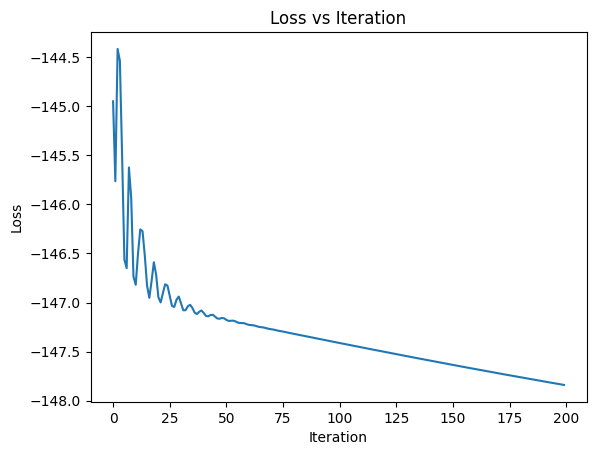

In [43]:
print(f'Best loss: {bestLoss}')
print(f'Best gamma: {bestGamma}')
print(f'Best sigma2: {bestSigma2}')
print(f'Best c: {bestc}')

plt.plot(losses)
plt.title('Loss vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [44]:
K = rbf_kernel(train_X, train_X, gamma=bestGamma, c=bestc)
evidence = -0.5*torch.logdet(K + (bestSigma2*torch.eye(len(train_X)))) - 0.5*(train_y.T @ torch.inverse(K + (bestSigma2*torch.eye(len(train_X)))) @ train_y)

print(f'Evidence: {evidence.item()}')

Evidence: 147.9120390616894


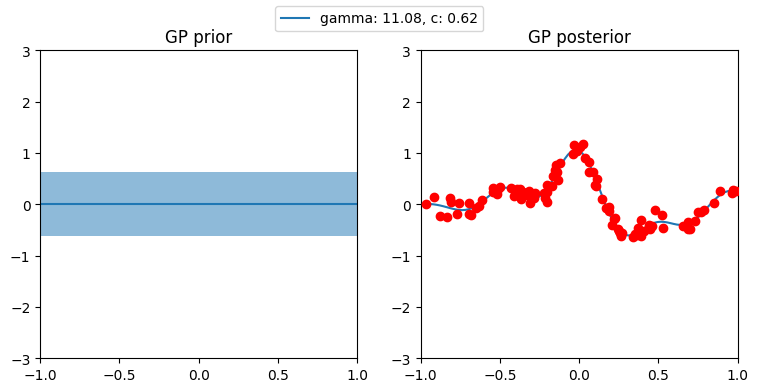

In [45]:
x = torch.linspace(-1, 1, 100)[:, None]

K = rbf_kernel(train_X, train_X, gamma=bestGamma, c=bestc) + torch.eye(x.shape[0])*bestSigma2
mu = torch.zeros_like(x)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))

axs[0].plot(x, mu)
axs[0].fill_between(x.flatten(), mu.flatten()-K.diag(), mu.flatten()+K.diag(), alpha=0.5)
axs[0].set_xlim([-1, 1])
axs[0].set_ylim([-3, 3])
axs[0].set_title('GP prior')

def posterior_pred(x, xt, yt, gamma=10.0, c=1.0, s2 = bestSigma2):
    Kxxt = rbf_kernel(x, xt, gamma, c)
    Kxt = rbf_kernel(xt, xt, gamma, c) + torch.eye(xt.shape[0])*s2
    Kinv = torch.linalg.inv(Kxt)
    Kxx = rbf_kernel(x, x, gamma, c)
    
    mu = Kxxt @ Kinv @ yt
    cov = Kxx - Kxxt @ Kinv @ Kxxt.T
    return mu, cov

post_mu, post_cov = posterior_pred(x, torch.tensor(train_X, dtype=torch.float32), 
                                   torch.tensor(train_y, dtype=torch.float32), 
                                   bestGamma, bestc, bestSigma2)

axs[1].plot(x, post_mu)
axs[1].fill_between(x.flatten(), post_mu.flatten()-post_cov.diag(), post_mu.flatten()+post_cov.diag(), alpha=0.5)
axs[1].scatter(train_X, train_y, color='red', zorder=5)

axs[1].set_xlim([-1, 1])
axs[1].set_ylim([-3, 3])
axs[1].set_title('GP posterior')

# add legend with gamma and c values
fig.legend(['gamma: {:.2f}, c: {:.2f}'.format(bestGamma, bestc)], loc='upper center')

plt.show()

Calculamos (i) a Log-Likelihood:

In [46]:
K = rbf_kernel(test_X, test_X, gamma=bestGamma, c=bestc)
LogMarginalLikelihood = -0.5*torch.logdet(K + (bestSigma2*torch.eye(len(test_X)))) - 0.5*(test_y.T @ torch.inverse(K + (bestSigma2*torch.eye(len(test_X)))) @ test_y)
print(f'Log Likelihood: {LogMarginalLikelihood.item()}')

Log Likelihood: 872.2551577806828


E (ii) o MSE em relação à média:

In [47]:
meanTest, _ = posterior_pred(torch.tensor(test_X), torch.tensor(train_X), torch.tensor(train_y), gamma, c, bestSigma2)
MSE = torch.mean((meanTest - torch.tensor(test_y))**2)
print(f'MSE: {MSE}')

MSE: 0.009948677629668688


# Exercício de "papel e caneta"

**1.** Na nota de aula, derivamos a posteriori preditiva $p(y_\star | x_\star, x_1, y_1, \ldots, x_N, y_N)$. Por simplicidade, deduzimos a priori preditiva $p(y_\star, y_1, \ldots, y_N | x_\star, x_1, \ldots, x_N)$ e as condicionamos nas saídas $y_1, \ldots, y_N$ observadas no conjunto de treino. No entanto, também é possível obter o mesmo resultado calculando a posteriori $p(f_\star, f_1, \ldots, f_N | x_\star, x_1, \ldots, x_N)$ e, então, calculando o valor esperado de $p(y_\star | x_\star, f_\star)$ sob essa posteriori. Deduza novamente a posteriori preditiva seguindo esse outro procedimento.

**Resposta:**

Conhecemos a forma da posteriori preditiva $p(y_*|y, x, x_*): = \int p(y_*|f_*, x, x_*)p(f_*|y, x, x_*)df_*$.

Para conseguirmos calcular este último termo da integral, partimos da distribuição conjunta $p(f_*, f, y | x, x_*)$, que pode ser reescrita como $p(f_*, f, y | x, x_*) = p(f_*|f, x, x_*)p(f|x)p(y|f)$. Partimos de uma Gaussiana, então ainda temos uma expressão composta por gaussianas. Matricialmente podemos escrever:

$$
\begin{bmatrix}
f_* \\
f \\
y
\end{bmatrix} \sim

\mathcal{N} \left( \begin{bmatrix}

\mu(f_*) \\
\mu(f) \\
\mu(y)

\end{bmatrix}, \Sigma
\right) = \mathcal{N} \left( \begin{bmatrix}
0 \\
0 \\
0
\end{bmatrix}, \Sigma
\right)
$$

Seguindo o mesmo raciocínio da nota de aula, temos que $\Sigma$ é a matriz de covariâncias com forma conhecida. Portanto, o que temos na prática é:

$$
\begin{bmatrix}
f_* \\
f \\
y
\end{bmatrix} \sim
\mathcal{N} \left( \begin{bmatrix}
0 \\
0 \\
0
\end{bmatrix}, \begin{bmatrix}

k(x_*, x_*) & k(x_*, x) & \text{cov}(f_*, y) \\
k(x, x_*) & k(x, x) & \text{cov}(f, y) \\
\text{cov}(y, f_*) & \text{cov}(y, f) & \text{cov}(y, y)

\end{bmatrix}
\right)
$$

Como estamos buscando $p(f_*|y, x, x_*)$ a partir de $$p(f_*, f, y | x, x_*)$, ainda há dois passos necessários: primeiro, marginalizar $f$; depois, condicionar em $y$. Marginalizar em $f$ é simples pelas propriedades de Gaussiana, e nos dá:

$$
\begin{bmatrix}
f_* \\
y
\end{bmatrix} \sim
\mathcal{N} \left( \begin{bmatrix}
0 \\
0 
\end{bmatrix}, \begin{bmatrix}
k(x_*, x_*) & \text{cov}(f_*, y) \\
\text{cov}(y, f_*) & \text{cov}(y, y)
\end{bmatrix}
\right)
$$

Agora, para condicionar em $y$, precisamos notar:

$$
\begin{align}
\text{cov}(f_*, y) &= \mathbb{E}_{f_*, y}[(f_* - \mathbb{E}[f_*])(y - \mathbb{E}[y])^T] \\
&= \mathbb{E}_{f_*, f, \epsilon}[(f_* - \mathbb{E}[f_*])(f + \epsilon - \mathbb{E}[f + \epsilon])^T] \\
&= \mathbb{E}_{f_*, f, \epsilon}[(f_* f + f_*\epsilon)] \\
&= \mathbb{E}_{f_*, f, \epsilon}[f_* f] + \mathbb{E}_{f_*, f, \epsilon}[f_*\epsilon] \\
&= k(x_*, x) + 0 \\
&= k(x_*, x)
\end{align}
$$

Com isso, podemos de fato condicionar em $y$. Basicamente, o condicionamento em $y$ implica que obteremos uma distribuição Gaussiana com média e covariância condicionais em $y$. O passo mostrado durante a aula mostrava que:

$$
\begin{align}
\mu_* &= k(x_*, x) (\text{cov}(y, y))^{-1}y \\
\Sigma_* &= k(x_*, x_*) - k(x_*, x) (\text{cov}(y, y))^{-1}k(x, x_*)

\end{align}
$$

Ou seja, encontramos os parâmetros da distribuição com função de probabilidade $p(f_*|y, x, x_*)$. Aprendemos que $f_*$ é a média de $y_*$. Ora, isso significa que podemos finalmente calcular a posteriori preditiva $p(y_*|y, x, x_*)$. O que antes era $\int p(y_*|f_*, x, x_*)p(f_*|y, x, x_*)df_*$ se torna $\int p(f_*|y_*, x, x_*)p(f_*|y, x, x_*)df_*$, ambas integrais com respeito a $f_*$. 

Utilizando a propriedade de multiplicação do Matrix Cookbook $\mathcal{N}_x(m_1, \Sigma_1) \mathcal{N}_x(m_2, \Sigma_2) = c_c \mathcal{N}_x(m_c, \Sigma_c)$. Naturalmente, índices 1 e 2 se referem à primeira e segunda distribuição, respectivamente. 

$c_c = \mathcal{N}_{m_1}(m_2, \Sigma_1 + \Sigma_2)$

E então concluímos que $p(y_*|y, x, x_*) \sim \mathcal{N}(\mu_*, \Sigma_* + \sigma^2 I)$. Naturalmente, conhecemos os valores de $\mu_*$ e $\Sigma_*$, e $\sigma^2$ é o parâmetro de ruído. Portanto, deduzimos a forma da posteriori preditiva $p(y_*|y, x, x_*)$ por outro caminho, obtendo o mesmo resultado:

$$
\begin{align}
p(y_*|y, x, x_*) &\sim \mathcal{N}(k(x_\star, x) (k(x, x)+\sigma^2 I)^{-1}y, 
&\sigma^2 +  k(x_\star, x_\star) - k(x_\star, x)(k(x, x)+\sigma^2 I)^{-1}k(x, x_\star))

\end{align}
$$


**2.** Quando trocamos a verossimilhança Gaussiana por uma Bernoulli (i.e., no caso de classificação binária), a posteriori para nosso GP não possui fórmula fechada. Mais especificamente, a verossimilhança para esse modelo é dada por $y | x \sim \text{Ber}(\sigma(f(x))$ onde $\sigma$ é a função sigmoide. Em resposta à falta de uma solução analítica, podemos aproximar a posteriori sobre $f$ para qualquer conjunto de pontos de entrada usando as técnicas de inferência aproximada que vimos anteriormente. Discuta como usar a Aproximação de Laplace nesse caso, incluindo as fórmulas para os termos da Hessiana. Além disso, discuta como usar o resultado desse procedimento para aproximar a posteriori preditiva.

Trata-se de uma Bernoulli, então a distribuição de probabilidade é dada por $p(y|f) = \sigma(f)^y(1-\sigma(f))^{1-y}$.

A posteriori que queremos aproximar usando Aproximação de Laplace é $p(y_*| x_*, x, y)$. Ela pode ser calculada por $\int p(y_*|x_*, y)p(f_*|x_*, x, y)df_*$. Num processo mais ou menos semelhante à questão anterior, avaliamos a integral em partes. Veja que:

$$p(f_*|x, x_*, y) = \int p(f_*|x, x_*, f) p(f| x_*, x, y)df$$

Sabemos pelas notas que aula que a manipulação de $ p(f_*|x, x_*, f)$ leva a uma distribuição normal $\mathcal{N}(0, k(x_*, x_*))$. Pelo exercício anterior, sabemos a forma matricial dessa distribuição. Ela terá:

$$\mu_* = k(x_*, x)(k(x, x)+\sigma^2_f I)^{-1}y$$
$$\Sigma_* = k(x_*, x_*) - k(x_*, x)(k(x, x)+\sigma^2_f I)^{-1}k(x, x_*)$$

Agora, para $p(f| x_*, x, y)$, temos que, aproximando por Laplace:

$$
p(f| x_*, x, y) = p(f)p(y|x, x_*, f)
$$

A distribuição $p(f)$ é dada por $\mathcal{N}(0, (k(x, x)+ \sigma^2_f I)^{-1})$. Já $p(y|x_*, x, f) = \prod^N_{i=1}p(y_i|f_i) = \prod^{N}_{i=1}e^{f_i y_i} \sigma(-f_i)$. O logaritmo da posteriori, o gradiente e a Hessiana são dados por:

$$
\begin{align}
\log p(f| x_*, x, y) &= \log p(f) + \log p(y|x, x_*, f) \\
&= -\frac{1}{2}f^T(k(x, x)+ \sigma^2_f I)^{-1}f + \sum^N_{i=1}f_i y_i - \sum^N_{i=1}\log(1+e^{f_i})
\end{align}

$$

$$
\begin{align}
\nabla \log p(f| x_*, x, y) &= -(k(x, x)+ \sigma^2_f I)^{-1}f + y - \sigma(f) \\
\end{align}

$$

$$
\begin{align}
\nabla^2 \log p(f| x_*, x, y) &= \sigma(f) (1-\sigma(f)) I - (k(x, x)+ \sigma^2_f I)^{-1}
\end{align}
$$

Obtivemos, assim, a aproximação de Laplace dada pela distribuição $q(f) = \mathcal{N}(f|f^*, (\nabla^2 \log p)^{-1})$. Usamos algum método iterativo para encontrar $f^*$, que é o ponto de máximo da posteriori. Dessa forma, munidos de duas distribuições normais, podemos calcular a integral que queríamos inicialmente, aproximando a posteriori preditiva.

## **ANOTAÇÕES**

Quando utilizamos uma priori gaussiana $\mathcal{N}(0, cI)$ sobre o vetor de pesos $\theta$, estamos definindo implicitamente uma priori para $f(X^\prime) = X^\prime \theta$. Como $f(X^\prime)$ é uma transformação linear de variáveis Gaussianas, a priori também é Gaussiana e o vetor de médias é $\mu({X^\prime}) = 0$ e matriz de covariância $\Sigma({X^\prime}, {X^\prime}) = cX^\prime X^{\prime T}$.

Abstrair $\theta$ e usar a priori sobre os valores de $f$ é o que chamamos de processo Gaussiano. 

A matriz de covariância é proporcional à matriz Gramiana K dos vetores linha de $X^\prime$, ou seja, $K_{ij} = x_i^\prime \times x_j^\prime$. Se incorporarmos uma função de expansão de base $\phi$, então $K_{ij} = \phi(x_i^\prime) \times \phi(x_j^\prime)$. Nesse caso, $f \sim \text{GP}(0, k)$.

### **Processos Gaussianos para Regressão**

Em geral, observamos a variável resposta $y_n$ com algum ruído, ou seja, $y = f(x) + \epsilon$, onde $\epsilon \sim \mathcal{N}(0, \sigma^2)$. Na prática, $y|x \sim \mathcal{N}(f(x), \sigma^2)$.

No que diz respeito ao processo preditivo, o modelo facilita na medid em que a combinação de priori e verossimilhança induz um processo Gaussiano sobre $g$. Somamos sempre uma $f(X^\prime)$ com uma variável aleatória $\epsilon$ que tem distribuição Gaussiana. Portanto, $g(X^\prime)$ é uma variável aleatória Gaussiana $\mathcal{N}(0, k(X^\prime, X^\prime) + \sigma^2 I)$.

Vamos considerar $X^\prime = [x_1, ..., x_N, x_*]$. O próximo passo é justamente condicionar aos dados observados. Até agora, tudo que obtivemos leva em consideração somente o que sabemos a priori. Podemos obter $p(y_*|x_*x_1, y_1, ..., x_N, y_n)$ condicionando a $g(X^\prime)$ nos valores observados $y_1, ..., y_N$, i.e., $p = \mathcal{N}(\mu_*, S_*)$:

$$

\mu_* = k(x_*, X) (k(X, X) + \sigma^2 I)^{-1} y \\

S_* = k(x_*, x_*) + \sigma^2 - k(x_*, X)(k(X, X) + \sigma^2 I)^{-1} (k(x_*, X))^T
$$

X é a matriz com os dados de treinamento e y é o vetor com as respostas. 

### **Parâmetros do kernel**

Como escolher os parâmetros do kernel? Em geral, maximizamos a esperança da verossimilhança sob a nossa priori, i.e., $p(y_1, ..., y_n|x_1, ..., x_N) = \mathbb{E}_{f \sim \text{GP}(0, k)}[\mathcal{N}(y|f(X), \sigma^2 I)]$. Se a função de kernel for $\omega$, então

$$\hat \omega = \dfrac{1}{2} \log \det (k(X, X) + \sigma^2 I) - \dfrac{1}{2}y^T(k(X, X) + \sigma^2 I)^{-1} y$$

é como encontrar os parâmetros ótimos do kernel (na prática, é uma manipulação para encontrar o máximo da $\log \text{verossimilhança} = \log p(y_1, ..., y_n|x_1, ..., x_N)$). Essa é a *type II maximum likelihood*, ou maximização da verossimilhança marginal. Em geral, o problema costuma não ser convexo para $\omega$ e rodamos SGD usando diferentes pontos iniciais, escolhendo o melhor ótimo local obtido.

$$
\begin{align}
p(f_\star, f_1, \ldots, f_N, y_1, \ldots, y_N, y_\star | x_\star, x_1, \ldots, x_N) &= p(y_\star | x_\star, f_\star) p(f_\star, f_1, \ldots, f_N, y_1, \ldots, y_N | x_\star, x_1, \ldots, x_N) \\
&= p(y_\star | x_\star, f_\star) p(f_\star | f_1, \ldots, f_N, y_1, \ldots, y_N, x_\star, x_1, \ldots, x_N) p(f_1, \ldots, f_N, y_1, \ldots, y_N | x_\star, x_1, \ldots, x_N) \\
&= p(y_\star | x_\star, f_\star) p(f_\star | f_1, \ldots, f_N, x_\star, x_1, \ldots, x_N) p(f_1, \ldots, f_N, y_1, \ldots, y_N | x_\star, x_1, \ldots, x_N) \\
&= p(y_\star | x_\star, f_\star) p(f_\star | x_\star, x_1, \ldots, x_N) p(f_1, \ldots, f_N, y_1, \ldots, y_N | x_\star, x_1, \ldots, x_N) \\
&= p(y_\star | x_\star, f_\star) p(f_\star | x_\star, x_1, \ldots, x_N) p(f_1, \ldots, f_N | y_1, \ldots, y_N, x_1, \ldots, x_N) p(y_1, \ldots, y_N | x_1, \ldots, x_N) \\
&= p(y_\star | x_\star, f_\star) p(f_\star | x_\star, x_1, \ldots, x_N) p(f_1, \ldots, f_N | y_1, \ldots, y_N, x_1, \ldots, x_N) \prod_{i=1}^N p(y_i | x_i, f_i)
\end{align}
$$